# High/Low Strategies

Momentum or trend-following strategies refer to trading strategies that rely on following a price trend to completion for profit. An example of a price trend is a sustained price increase due to good earnings beating expectations. 

Momentum strategies use various technical indicators to open a trade when a trend begins and exits when the trend ends. These strategies can be long or short. Momentum strategies is usually contrasted with mean-reversion strategies where traders believe that prices should revert to an expected value. An example of a mean reversion strategy is pairs trading.

Momentum strategies are generally characterised by a low win-rate due to whipsaw losses (indicated trends did not materialise) with great returns from a few winning trades, compared to lower, but more consistent profits for mean reversion trades. This generally produces a lower sharpe ratio for momentum strategies.

Technical indicators for entry include:
- Moving average crossover
- Breakout from highest value in rolling window
- Breakout from All-Time-High

Exit indicators include:
- Moving average crossover
- Breakout from lowest value in rolling window
- Trailing stop



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester
from mpl_toolkits.mplot3d import Axes3D



ticker = 'SPY'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

Generate indicators for entry and exit

In [2]:
def generate_high_low(df, high_window, low_window):

    df['up_bound'] = df['high'].shift(1).rolling(high_window).max()
    df['low_bound'] = df['low'].shift(1).rolling(low_window).min()

    return df

def generate_atr(df, window):
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window).mean()

    return df

def generate_sma(df, long_window, short_window):
    df['long_sma'] = df['close'].rolling(long_window).mean().shift(2)
    df['short_sma'] = df['close'].rolling(short_window).mean().shift(2)

    return df

### High/Low Breakout

In [3]:
def hl_backtest(df, high_window, low_window):

    df = generate_high_low(df, high_window, low_window)

    df.dropna(inplace=True)

    df['signal'] = 0

    # Generate trading signals
    df.loc[df['high'] > df['up_bound'].shift(1), 'signal'] = 1
    df.loc[df['low'] < df['low_bound'].shift(1), 'signal'] = -1
    

    trades_arr = df['signal'].to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.close[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            

        # open trades present 
        elif trades_arr[i] == -1 and open_trade != None:

            order_price = bt.close[i]
            order_quantity = -open_trade.quantity
                
            open_trade.close(bt.date[i], order_price)
            tl.append(open_trade)
            
            open_trade = None

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
        
    
    return bt, tl

In [4]:
hl_period = np.arange(1, 501, 5)
results = []

for i in range(len(hl_period)):
    for j in range(len(hl_period)):
        # print(i, j)
        bt, _ = hl_backtest(df.copy(), hl_period[i], hl_period[j])
        bt.analyse()
        results.append((hl_period[i], hl_period[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [5]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')


Buy Hold Results
Annual Return = 0.1504965153116664
Annual Volatility = 0.19343567868891676
Sharpe Ratio = 0.7780183900494122
-----------
Max Total Returns:
High Window = 66, Low Window = 491
Annual Return = 0.1427351785957811
Annual Volatility = 0.15762559861464295
Sharpe Ratio = 0.9055329835399047
-----------
Max Sharpe Ratio:
High Window = 96, Low Window = 191
Annual Return = 0.12725018568635482
Annual Volatility = 0.1280616613151495
Sharpe Ratio = 0.9936633991745765
-----------


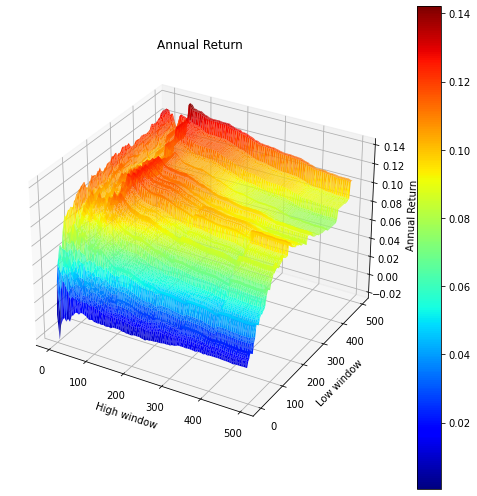

In [6]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

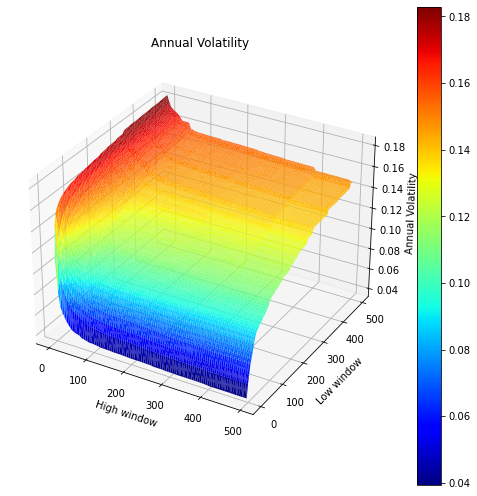

In [7]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Volatility')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

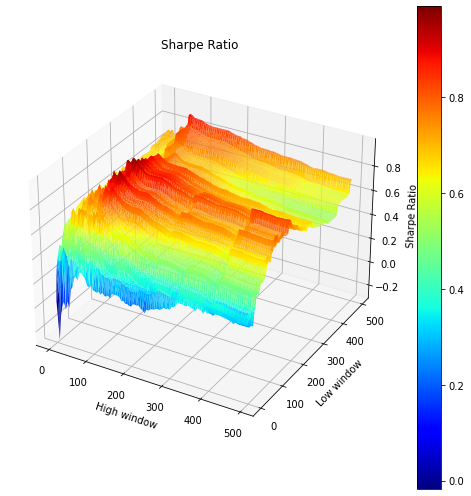

In [8]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

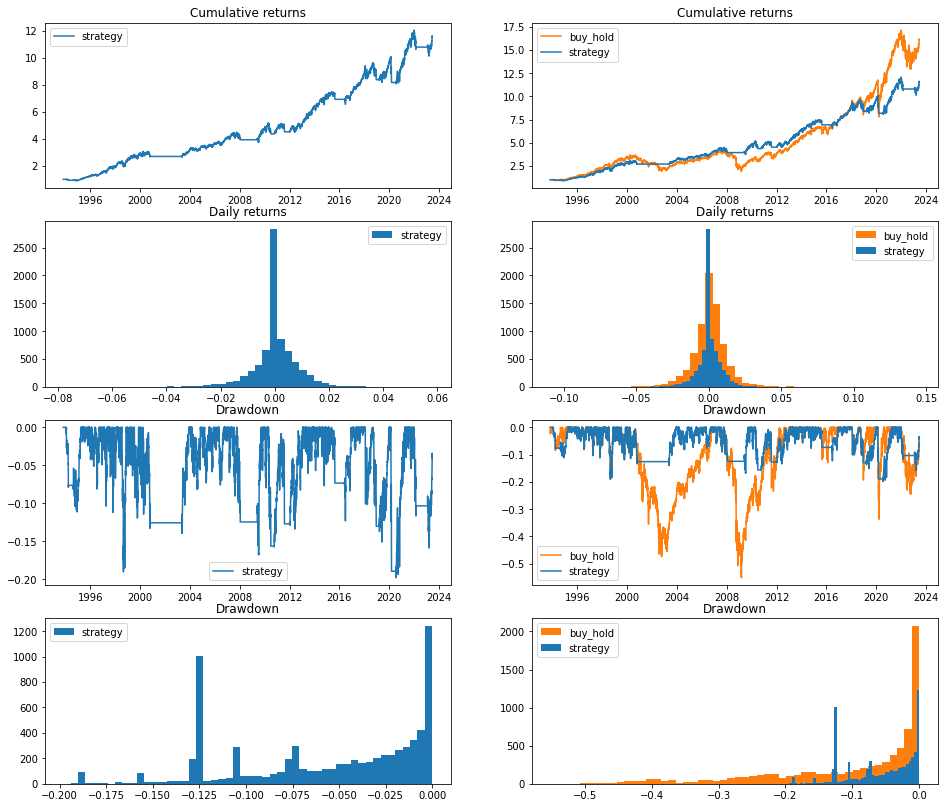

In [9]:
bt, tl = hl_backtest(df.copy(), best_sr[0], best_sr[1])

bt.analyse()
bt.plot_graphs()

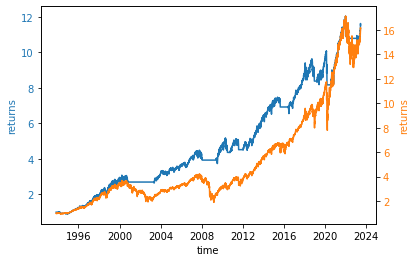

In [10]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [11]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.12725018568635482
buy_hold annual return:     0.14585484896741518
---------
Annualised vol:             0.1280616613151495
buy_hold annual vol:        0.19052228613281333
---------
Sharpe ratio:               0.9936633991745765
buy_hold Sharpe ratio:      0.7655526916454256


### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [12]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 7,
 'num_loss': 2,
 'win_rate': 0.7777777777777778,
 'profit_total': 9794271.221023563,
 'profit_mean': 1088252.357891507,
 'returns_mean': 0.38416400200110534,
 'returns_std': 0.5977836492429306,
 'time_in_trade_mean': 882.8888888888889,
 'time_in_trade_std': 736.9286675867014,
 'capital_at_risk_mean': 4549132.725694444,
 'win_returns_mean': 0.506540195114257,
 'win_returns_std': 0.6306488037539835,
 'win_profit_mean': 1438460.6349160336,
 'win_time_in_trade_mean': 1072.0,
 'win_time_in_trade_std': 727.8065219090396,
 'loss_returns_mean': -0.04415267389492577,
 'loss_returns_std': 0.0267015013108994,
 'loss_profit_mean': -137476.61169433594,
 'loss_time_in_trade_mean': 221.0,
 'loss_time_in_trade_std': 199.4041122946064}

We plot every single trade to view the characteristics of each trade.

No handles with labels found to put in legend.


trade 0
entry: [47.59375]
cost_basis: 47.59375
exit: 44.59375
returns: -0.06303348653972422


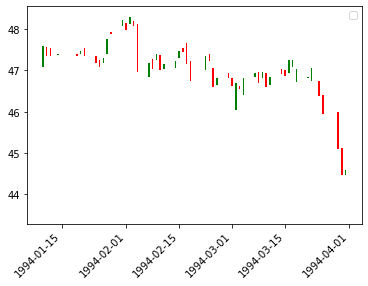

trade 1
entry: [46.640625]
cost_basis: 46.640625
exit: 134.25
returns: 1.8783919597989949


No handles with labels found to put in legend.


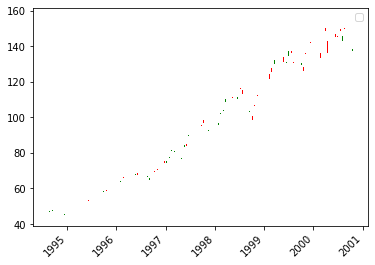

trade 2
entry: [93.91000366210938]
cost_basis: 93.91000366210938
exit: 136.97999572753906
returns: 0.4586305013936176


No handles with labels found to put in legend.


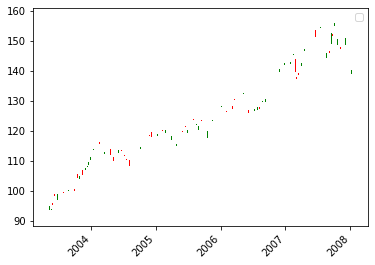

trade 3
entry: [92.52999877929688]
cost_basis: 92.52999877929688
exit: 102.76000213623048
returns: 0.11055877544464553


No handles with labels found to put in legend.


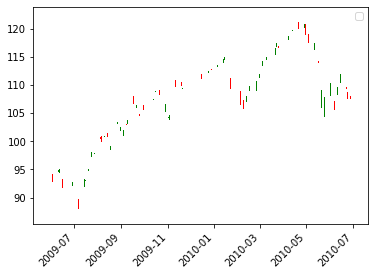

trade 4
entry: [116.04000091552734]
cost_basis: 116.04000091552734
exit: 120.08000183105467
returns: 0.03481558844926497


No handles with labels found to put in legend.


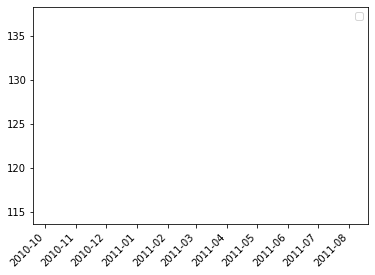

trade 5
entry: [129.1300048828125]
cost_basis: 129.1300048828125
exit: 197.8300018310547
returns: 0.5320219495893964


No handles with labels found to put in legend.


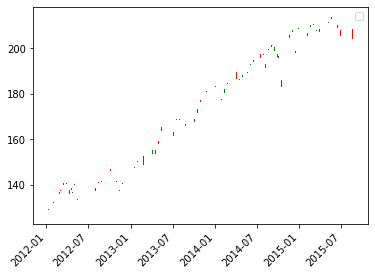

trade 6
entry: [210.91000366210935]
cost_basis: 210.91000366210935
exit: 255.3600006103516
returns: 0.21075338379612302


No handles with labels found to put in legend.


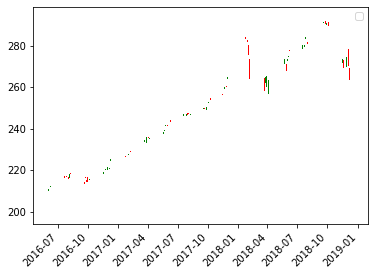

trade 7
entry: [281.3399963378906]
cost_basis: 281.3399963378906
exit: 274.2300109863281
returns: -0.025271861250127318


No handles with labels found to put in legend.


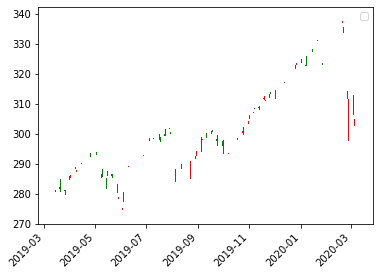

trade 8
entry: [324.32000732421875]
cost_basis: 324.32000732421875
exit: 428.2999877929688
returns: 0.32060920732775683


No handles with labels found to put in legend.


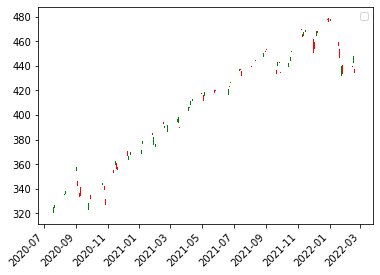

In [13]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

No handles with labels found to put in legend.


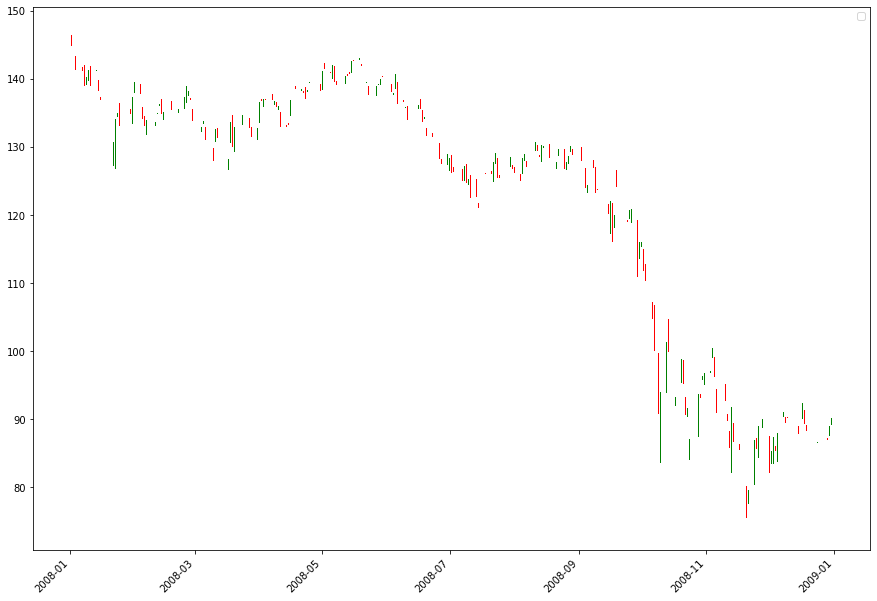

In [14]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

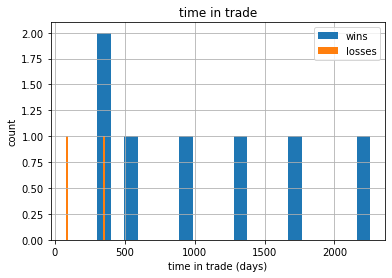

In [15]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

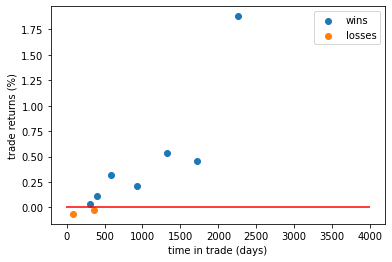

In [16]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 4000, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.